# Import

In [ ]:
%pip install seaborn scikit-learn scipy

In [ ]:
import os
from sklearn.experimental import enable_halving_search_cv
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import (roc_auc_score, f1_score, log_loss, precision_score, 
                             recall_score, confusion_matrix, RocCurveDisplay, make_scorer, roc_curve)
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

# Load/Split

Skup podataka: https://archive.ics.uci.edu/dataset/374/appliances+energy+prediction

In [ ]:
file_path = './dataset.csv'
df = pd.read_csv(file_path, sep=',')

# Priprema i analiza podataka

## Opis podataka

- $id$
- $track\_id$ - jedinstveni id pesme
- $artists$ - izvođači, razdvojeni ';'
- $album\_name$ - ime albuma
- $track\_namet$ - ime pesme
- $popularity$ - vrednost od 0 do 100, bazirana na tome koliko često je pesma puštana na Spotify-u u skorije vreme
- $duration\_ms$ - trajanje pesme u ms
- $explicit$ - da li pesma sadrži eksplicitan tekst
- $danceability$ - koliko je pesma "plesljiva" - od 0 do 1
- $energy$ - koliko je pesma energična (0 do 1), određena na osnovu više odlika pesme (brzina, koliko je pesma glasna...)
- $key$ - u kojoj lestvici je pesma
- $loudness$ - koliko je pesma glasna u dB
- $mode$ - da li je dur ili mol lestvica (1 - dur, 0 - mol)
- $speechiness$ - koliko je zastupljen tekst u pesmi - 0 do 1
- $acousticness$ - verovatnoća da je pesma akustična - 0 do 1
- $instrumentalness$ - verovatnoća da je pesma instrumental - 0 do 1, 1 označava veliku verovatnoću da nema vokala u pesmi
- $liveness$ - verovatnoća da je pesma izvedena u javnosti (koncert) - 0 do 1
- $valence$ - koliko je pesma vesela - 1 predstavlja srećne pesme dok 0 su tužnije pesme
- $tempo$ - brzina pesme u bitovima po minutu
- $time\_signature$ - ritam, takt
- $track\_genre$ - žanr pesme, ciljni atribut

In [ ]:
print(f"Broj ulaza u skupu podataka: {len(df)}")

In [ ]:
print(f"Broj ulaznih promenljivih u skupu podataka: {len(df.iloc[0])}")

- Ukupno imamo <span style="color:#03d3fc">20 ulazne promenljive</span> i <span style="color:#fc036f">1 ciljnu promenljivu</span>
- Ukupno imamo <span style="color:#03d3fc">114000 ulaza u skupu podataka</span>
- Koristimo 80-20 podelu za trening i test skup

In [ ]:
df.info()

- Nema nedostajućih vrednosti u skupu
- $track\_id$, $artists$, $album\_name$, $track\_name$, $track\_genre$ su object

## Obrada atributa

$track\_id$ atribut možemo da izbacimo kao i $Unnamed: 0$ koji predstavljaju samo identifikatore

In [ ]:
df.drop(labels=['track_id','Unnamed: 0'],inplace=True, axis=1)

$artists$ atribut analiziramo

In [ ]:
report = {
    'maximum_artists_on_single_track': 0,\
    'unique_artist_count':0,
    'longest_artist_list':'',
    'missing_artists_index':[]
}
artists= df['artists'].str.split(';')
unique_artists = []
for i,artist_list in enumerate(artists):
    try:
        if len(artist_list) > report['maximum_artists_on_single_track']:
            report['maximum_artists_on_single_track'] = len(artist_list)
            report['longest_artist_list'] = artist_list

        report['maximum_artists_on_single_track'] = max(report['maximum_artists_on_single_track'], len(artist_list))
        for artist in artist_list:
            if artist in unique_artists: continue
            unique_artists.append(artist)
    except:
        report['missing_artists_index'].append(i)
report['unique_artist_count'] = len(unique_artists)

In [ ]:
report

- Pesma sa najviše izvođača ima 38 izvođača
- Postoji pesma bez ijednog izvođača - pesma sa indeksom 65900, koju izbacujemo
- Postoje 29859 jedinstvenih izvođača
- Moramo da zamenimo atribut artists nekim drugim atributom
    - Jedan izbor je da zamenimo brojem izvođača, pesme sa velikim brojem izvođača su najverovatnije retkost
    - Drugi izbor je da zamenimo sa indeksima izvođača, međutim to zahteva 38 dodatnih atributa u najgorem slučaju, a takođe bi loše funkcionisalo sa pojavom novih izvođača
    

In [ ]:
print('Before: ', len(df))
df.drop(labels=report['missing_artists_index'], inplace=True, axis=0)
print('After: ', len(df))

In [ ]:
df['artists'] = df['artists'].str.split(';')
df['artists'] = df['artists'].apply(len)

In [ ]:
df.describe()

- Kao što smo pretpostavili, većina pesama ima samo 1 izvođača, prosek je 1.388 izvođača po pesmi

Atribute $track\_name$ i $album\_name$ možemo takođe da zamenimo dužinom imena

In [ ]:
df['track_name'] = df['track_name'].apply(len)
df['album_name'] = df['album_name'].apply(len)

Na kraju trebamo još da enkodiramo atribut za žanr

In [ ]:
label_encoder = LabelEncoder()

df['track_genre'] = label_encoder.fit_transform(df['track_genre'])

In [ ]:
df['explicit'] = df['explicit'].apply(int)

In [ ]:
df.info()

In [ ]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

## Raspodele podataka

In [ ]:
def visualize_attribute(train: pd.DataFrame, attribute: str) -> None:
    plt.figure(facecolor='darkblue')
    color = np.random.rand(3,)
    _, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    sns.histplot(data=train, x=attribute, kde=False, ax=axes[0, 0], color=color)
    axes[0, 0].set_title('Histogram')
    
    sns.boxplot(data=train, x=attribute, ax=axes[0, 1], color=color)
    axes[0, 1].set_title('Boxplot')
    
    sns.violinplot(data=train, x=attribute, ax=axes[1, 0], color=color)
    axes[1, 0].set_title('Violin Plot')
    
    sns.scatterplot(data=train, x=attribute, y='track_genre', ax=axes[1, 1], color=color, alpha=0.2)
    axes[1, 1].set_title('Scatter Plot')
    
    plt.show()

attributes = list(train.keys())
for attribute in attributes:
    visualize_attribute(train, attribute)

**Prvi zaključci**
- Pesme sa većem brojem izvođača uglavnom pripadaju žanrovima sa višim indeksom
- Takođe pesme sa dužim imenima albuma češće pripadaju žanrovima sa višim indeksom
- Pesme trajanja iznad 2*10e6 ms su retke ali zastupljene među svim žanrovima
- Pesme sa više teksta obično pripadaju žanrovima sa indeksom oko 20
- Pesme sa sporijim ritmom su retke, zastupljene u svim žanrovima ali najviše kod žanrova sa višim indeksom

## Normalizacija atributa

In [ ]:
def transform_skewed_attributes(train, transf_map:dict = {}, skew_threshold=0.1):
    transformer = PowerTransformer(method='yeo-johnson')
    train_cp = train.copy()
    for column in train_cp.columns:
        if train_cp[column].dtype in [np.float64, np.int64]:
            skewness = train_cp[column].skew()
            if abs(skewness) > skew_threshold:
                transformer = PowerTransformer(method='yeo-johnson')
                transformer = transformer.fit(train_cp[[column]])
                train_cp[column] = transformer.transform(train_cp[[column]])
                if column in transf_map.keys():
                    transf_map[column].append(transformer)
                else:
                    transf_map[column] = [transformer]

    return train_cp

def scale(train, transf_map:dict = {}):
    train_cp = train.copy()
    for column in train.columns:
        if train_cp[column].dtype in [np.float64, np.int64]:
            scaler = MinMaxScaler(feature_range=(-1, 1))
            scaler = scaler.fit(train_cp[[column]])
            train_cp[column] = scaler.transform(train_cp[[column]])
            if column in transf_map.keys():
                    transf_map[column].append(scaler)
            else:
                transf_map[column] = [scaler]
    return train_cp

def apply_transf(X, transf_map:dict):
    result = X.copy()
    for attribute in transf_map.keys():
        for tr in transf_map[attribute]:
            result[attribute] = tr.transform(result[[attribute]])
    return result

# Preliminarni trening

- TODO:
    - Funkcija koja primi podatke i labele i niz test primera
        - Test primer ima jedno polje koje sadrzi niz transformacija, jedno polje koji algoritam koristi i jedno polje za tuning
        - Ubaci rezultate u dataframe - auc, roc, f1, log_loss, prec, recall
        - Vizuelizuje - matrica konfuzije, feature importance dijagram, AUC/ROC
        - Vraća istrenirani model
    - Primeni funkciju za:
        - Za svaku od transforms stavki tune-uj razne algoritme nad njima sa halvigGrid ili halvingRandom

In [ ]:
def train_test_model(X, y, model, param_grid, result_df, tag=None):
    # Ensure y is a 1D array of class labels
    y = y.values.ravel()  # Flatten y to be a 1D array
    
    # Define the custom scorer for multi-class ROC AUC
    custom_scorer = make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr')
    f1_scorer = make_scorer(f1_score, average='macro')


    # Perform hyperparameter tuning using HalvingGridSearchCV
    halving_search = HalvingRandomSearchCV(model, param_grid, scoring=f1_scorer, n_jobs=-1, cv=3, verbose=0, n_candidates=80)
    halving_search.fit(X, y)
    
    # Get the best model
    best_model = halving_search.best_estimator_
    
    # Predict on the entire dataset
    y_pred = best_model.predict(X)
    
    # Calculate evaluation metrics
    # For ROC AUC, it requires probabilities
    if hasattr(best_model, 'predict_proba'):
        y_pred_prob = best_model.predict_proba(X)
        auc = roc_auc_score(y, y_pred_prob, multi_class='ovr')
    else:
        auc = np.nan
    
    f1 = f1_score(y, y_pred, average='macro')
    precision = precision_score(y, y_pred, average='macro')
    recall = recall_score(y, y_pred, average='macro')

    
    # Print results
    print(f"Model: {type(model).__name__}")
    print(f"AUC: {auc:.4f}")
    print(f"F1: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Best Params: {halving_search.best_params_}")
    
    # Store results in the results dataframe
    tag = "_" + tag if tag is not None else ""
    results = pd.DataFrame([{
        'Model': type(model).__name__ + tag,
        'AUC': auc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall,
        'Best Params': halving_search.best_params_
    }])
    result_df = pd.concat([result_df, results], ignore_index=True)
    
    # Visualizing the results
    
    # Confusion matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()
    
    # Feature importance (if applicable)
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.figure(figsize=(10, 6))
        plt.title('Feature Importances')
        plt.bar(range(X.shape[1]), importances[indices], color='r', align='center')
        if X is pd.DataFrame:
            plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
        else:
            plt.xticks(range(X.shape[1]), indices, rotation=90)
        plt.xlim([-1, X.shape[1]])
        plt.show()
    
    print(results)
    return best_model, result_df

def apply_transf_list(data, transforms):
    d = data.copy()
    for t in transforms:
        d = t(d)
        if t is PCA:
            d = pd.DataFrame(d, columns=[f'PC{i+1}' for i in range(d.shape[1])])
    return d


In [ ]:
ss = scale
norm = transform_skewed_attributes
pca = PCA(n_components=0.97)
transforms = [('None',[]), ('PCA',[pca.fit_transform])]

In [26]:
models = []
models.append((RandomForestClassifier, {
    'n_estimators': [100, 300, 500],           
    'max_depth': [None, 5, 7, 13],                    
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]                           
}))
models.append((AdaBoostClassifier, {
    'n_estimators': [50, 100, 150, 200, 250],  
    'learning_rate': [0.01, 0.1, 1.0, 1.5, 2.0],  
    'estimator': [
        DecisionTreeClassifier(max_depth=5),
        DecisionTreeClassifier(max_depth=13),
        DecisionTreeClassifier(max_depth=None)
    ] 
}))
models.append((HistGradientBoostingClassifier, {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],         
    'max_iter': [100, 200, 300],                     
    'max_leaf_nodes': [15, 31, 63],                  
    'max_depth': [3, 5, 7],                          
    'min_samples_leaf': [10, 20, 30],                
    'max_bins': [255, 510],                         
    'l2_regularization': [0, 0.1, 1],                
    'early_stopping': [True, False]                  
}))
models.append((ExtraTreesClassifier, {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [False, True]
}))

In [ ]:
y = train['track_genre']
train.drop(['track_genre'],inplace=True, axis=1)

In [ ]:
results = pd.DataFrame()
best_models = []

In [ ]:
tag, transform_list = transforms[0]
model, grid = models[0]
m, results = train_test_model(apply_transf_list(train, transform_list), y, model(), grid, results, tag)
best_models.append(m)

In [ ]:
tag, transform_list = transforms[1]
model, grid = models[0]
m, results = train_test_model(apply_transf_list(train, transform_list), y, model(), grid, results, tag)
best_models.append(m)

In [ ]:
tag, transform_list = transforms[0]
model, grid = models[1]
m, results = train_test_model(apply_transf_list(train, transform_list), y, model(), grid, results, tag)
best_models.append(m)

In [ ]:
tag, transform_list = transforms[1]
model, grid = models[1]
m, results = train_test_model(apply_transf_list(train, transform_list), y, model(), grid, results, tag)
best_models.append(m)

In [ ]:
tag, transform_list = transforms[0]
model, grid = models[2]
m, results = train_test_model(apply_transf_list(train, transform_list), y, model(), grid, results, tag)
best_models.append(m)

In [ ]:
tag, transform_list = transforms[1]
model, grid = models[2]
m, results = train_test_model(apply_transf_list(train, transform_list), y, model(), grid, results, tag)
best_models.append(m)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site

Model: ExtraTreesClassifier
AUC: 0.9985
F1: 0.8157
Precision: 0.8220
Recall: 0.8171
Best Params: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': False}


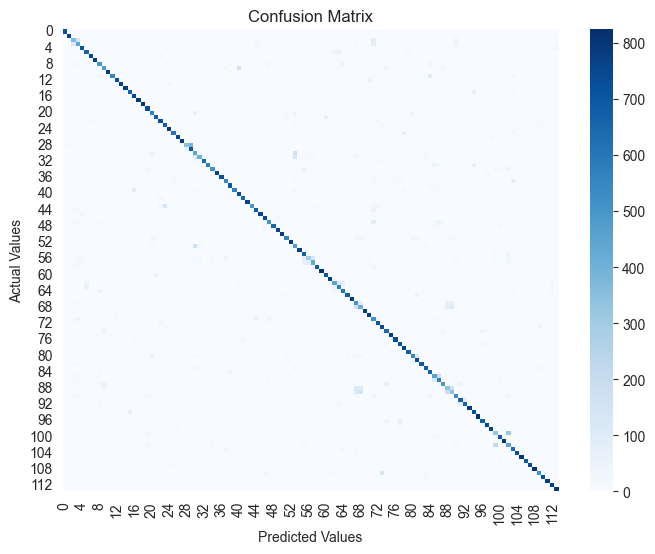

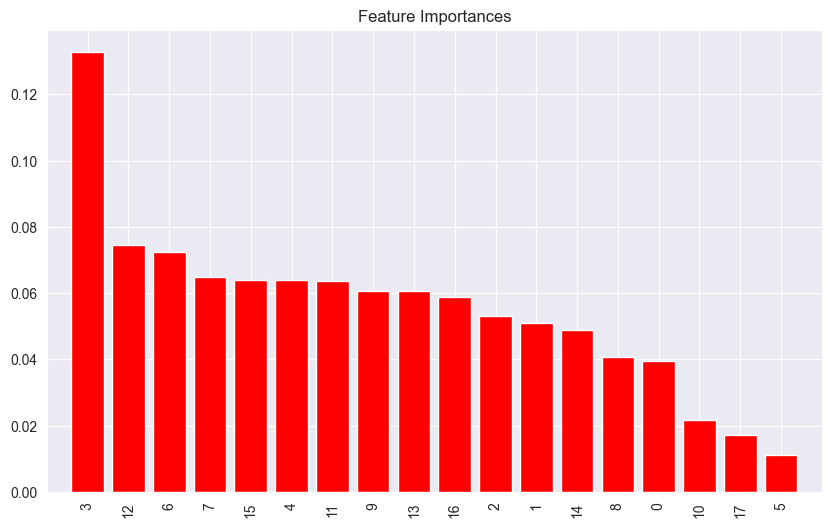

                       Model      AUC        F1  Precision    Recall  \
0  ExtraTreesClassifier_None  0.99846  0.815695   0.822019  0.817074   

                                         Best Params  
0  {'n_estimators': 500, 'min_samples_split': 2, ...  


In [27]:
tag, transform_list = transforms[0]
model, grid = models[3]
m, results = train_test_model(apply_transf_list(train, transform_list), y, model(), grid, results, tag)
best_models.append(m)

In [ ]:
tag, transform_list = transforms[1]
model, grid = models[3]
m, results = train_test_model(apply_transf_list(train, transform_list), y, model(), grid, results, tag)
best_models.append(m)